# Open the dataset using ImageDataGenerator

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_path = '/kaggle/input/rice-leaf-disease-image'
generator = ImageDataGenerator(rescale=1./255,
                               validation_split=0.2)

train_datagen = generator.flow_from_directory(main_path,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              batch_size=32,
                                              subset='training')

valid_datagen = generator.flow_from_directory(main_path,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              batch_size=16,
                                              subset='validation')

Found 4747 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.


# Making model

## Making "Block" class to build custom set of layers

In [3]:
class Block(tf.keras.Model):
    
    def __init__(self, filters, kernel_size, reps):
        
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.reps = reps
        
        for i in range(0, self.reps):
            vars(self)[f'conv2d_{i}'] = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu')
            
        self.maxpooling2d = tf.keras.layers.MaxPooling2D(2, 2)
        
    def call(self, inputs):
        
        conv2d = vars(self)['conv2d_0']
        x = conv2d(inputs)
        
        for i in range(1, self.reps):
            conv2d_i = vars(self)[f'conv2d_{i}']
            x = conv2d_i(x)
        
        maxpooling2d = self.maxpooling2d(x)
        
        return maxpooling2d

## Implement the "Block" with functional API

In [4]:
inputs = tf.keras.Input((224,224,3))
x = Block(64, 2, 1)(inputs)
x = Block(128, 2, 1)(x)
x = Block(256, 3, 1)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, x)

## Compile the model

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Build callback class

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95:
            self.model.stop_training = True

# Train the model

In [7]:
callback = myCallback()
history = model.fit(train_datagen,
          epochs=200,
          validation_data=valid_datagen,
          callbacks=callback)

Epoch 1/200
149/149 [==============================] - 50s 305ms/step - loss: 1.4698 - accuracy: 0.5652 - val_loss: 1.1701 - val_accuracy: 0.5122
Epoch 2/200
149/149 [==============================] - 18s 122ms/step - loss: 0.7554 - accuracy: 0.7049 - val_loss: 0.6747 - val_accuracy: 0.7418
Epoch 3/200
149/149 [==============================] - 20s 133ms/step - loss: 0.5619 - accuracy: 0.8028 - val_loss: 0.5111 - val_accuracy: 0.8295
Epoch 4/200
149/149 [==============================] - 19s 127ms/step - loss: 0.4585 - accuracy: 0.8464 - val_loss: 0.4565 - val_accuracy: 0.8633
Epoch 5/200
149/149 [==============================] - 19s 125ms/step - loss: 0.3727 - accuracy: 0.8793 - val_loss: 0.6439 - val_accuracy: 0.7485
Epoch 6/200
149/149 [==============================] - 19s 124ms/step - loss: 0.3087 - accuracy: 0.9044 - val_loss: 0.3881 - val_accuracy: 0.8608
Epoch 7/200
149/149 [==============================] - 18s 121ms/step - loss: 0.2695 - accuracy: 0.9124 - val_loss: 0.2938 -

# Training result / history plotting

In [8]:
import matplotlib.pyplot as plt

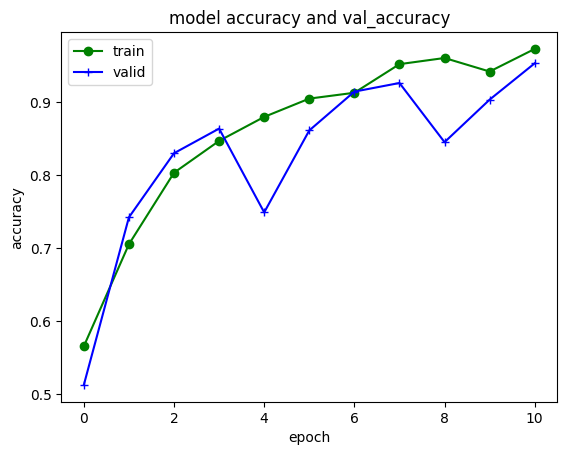

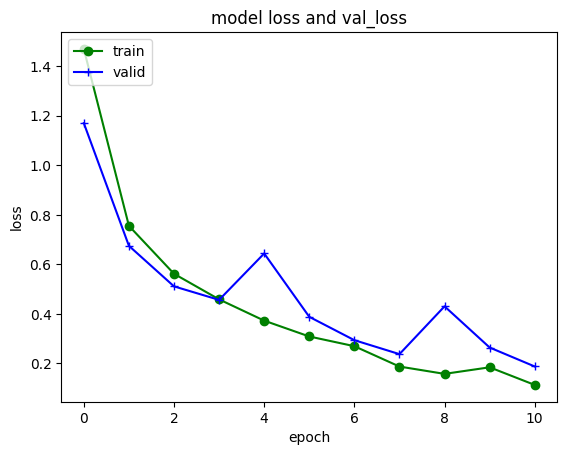

In [9]:
acc_loss = [['accuracy', 'val_accuracy'],
            ['loss', 'val_loss']]

for i in acc_loss:
    
    plt.plot(history.history[i[0]], 'g-o')
    plt.plot(history.history[i[1]], 'b-+')
    plt.title(f'model {i[0]} and {i[1]}')
    plt.ylabel(f'{i[0]}')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    

# Evaluate the model using training datagen

In [10]:
model.evaluate(train_datagen)

149/149 [==============================] - 15s 102ms/step - loss: 0.0817 - accuracy: 0.9897


[0.0817275121808052, 0.9896776676177979]